### Extract satellite data at VOR plots for standing biomass modelling

#### Package inputs

In [1]:
import xarray as xr
import rioxarray as riox
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import time
import json
from shapely import wkt
from itertools import chain
from hlsstack.hls_funcs import fetch
from hlsstack.hls_funcs.masks import mask_hls, shp2mask, bolton_mask, atsa_mask
from hlsstack.hls_funcs.indices import ndvi_func
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
import gc
from glob import glob

#### Specify parameters

##### Specify input/output paths

In [2]:
# path to plot data
plot_shp = '../data/ground/boundaries/CPER_plots_from_vor_transects.shp'
# path to cper pasture data
cper_shp = '../data/ground/boundaries/cper_pastures_2017_dissolved.shp'
# directory for landsat-modis fusion (LMF) data in netcdf form
lmfDIR = '/mnt/e/LMF_STARFM_netcdf/'
#lmfDIR = '/mnt/t/3-GIS/CPER/Layers/CPER_Landsat-Modis-Fusion_V3'

# output paths
outPATH_ndvi = '../data/training/iapar/cper_ndvi_plotscale_2000_2022.csv'
outPATH_fnl = '../data/training/iapar/cper_apar_plotscale_2000_2022.csv'

##### Specifiy other parameters

In [3]:
# dask cluster location
cluster_loc = 'local'

# whether use Landsat-MODIS (LMF) fusion data when available
use_lmf = True
# last year for LMF data
lmf_yr_max = 2015
# whether to try applying the ATSA cloud/shadow mask
try_atsa = True
# whether to apply the Bolton et al. masking approach
mask_bolton = False

##### Set up dask cluster

In [4]:
if cluster_loc == 'local':
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    aws=False
    # don't process on local resources - can't handle ATSA mask
    process_hls = False
    fetch.setup_env(aws=aws)
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
elif cluster_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    from jupyter_server import serverapp
    # get the server address for porting
    try:
        jupServer = [x for x in serverapp.list_running_servers()][0]
    except IndexError:
        # manually copy/paste the server address
        jupServer = {'base_url': '/node/ceres19-compute-98-eth.scinet.local/17710/'}
    print('   setting up cluster on HPC...')
    aws=False
    process_hls = True
    fetch.setup_env(aws=aws)
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    partition='short',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 2.5*num_processes*num_threads_per_processes
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem)+'GB',
                            #interface='ib0',
                            interface='enp24s0f0',
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=16
    clust.scale(jobs=num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    except dask.distributed.TimeoutError as e:
        print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
        #print(e)
        pass
    display(client)

   setting up Local cluster...


/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45647 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45647/status,
Dashboard: http://127.0.0.1:45647/status,Workers: 8
Total threads: 16,Total memory: 11.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42841,Workers: 8
Dashboard: http://127.0.0.1:45647/status,Total threads: 16
Started: Just now,Total memory: 11.85 GiB
Comm: tcp://127.0.0.1:33635,Total threads: 2
Dashboard: http://127.0.0.1:42367/status,Memory: 1.48 GiB
Nanny: tcp://127.0.0.1:37953,


#### Create helper functions

In [5]:
def ndvi_to_fpar(ndvi_ts):
    SR = (1 + ndvi_ts) / (1 - ndvi_ts)
    # SR_min = 1.55  # this is based on Grigera et al., 2007
    SR_min = 1.11  # this is based on an NDVI of 0.05
    SR_max = 11.62
    fPAR = SR / (SR_max - SR_min) - SR_min / (SR_max - SR_min)
    return fPAR

#### Load and prepare datasets

##### Load data

In [6]:
gdf_plot = gpd.read_file(plot_shp)
gdf_cper = gpd.read_file(cper_shp)

##### Prepare pasture and plot data for CARM and LTGI

In [7]:
# add LTGI as a treatment
gdf_cper.loc[gdf_cper['Past_Name_'].isin(['23E', '28N', '1W', '32W']), 'Treatment'] = 'Heavy'

In [8]:
# bring in treatment label to plot data
gdf_plot = pd.merge(gdf_plot, gdf_cper[['Past_Name_', 'Treatment']],
                    how='left', left_on='PastureNm', right_on='Past_Name_')

In [9]:
# subset plot data to only the CARM (AGM) and LTGI pastures
gdf_plot = gdf_plot[gdf_plot['Treatment'].isin(['AGM', 'TGM', 'Heavy'])]

#### Extract daily NDVI

##### Prep output file

In [10]:
# load any existing output data
if os.path.exists(outPATH_ndvi):
    df_out_ndvi = pd.read_csv(outPATH_ndvi, parse_dates=[2, 3])
else:
    df_out_ndvi = None

##### Loop through years and extract and smooth NDVI from LMF or HLS

In [11]:
for yr in range(2000, 2023):
    # set the bounding box for fetching data
    bbox = np.array(gdf_plot.total_bounds) # the entire subset dataset
    if use_lmf and yr <= lmf_yr_max:
        # get the LMF netcdf dataset for the year
        lmfPATH_yr = glob(os.path.join(lmfDIR, 'CPER_' + str(yr) + '*.nc'))
        # load the dataset to memory after masking
        lmf_ds = riox.open_rasterio(lmfPATH_yr[0], 
                      nodata=-9999, mask=True).sel(x=slice(bbox[0], bbox[2]),
                                                   y=slice(bbox[3], bbox[1]))
        # chunk the dataset for efficient processing and save as a new dataset
        sat_ds = lmf_ds.chunk({'DOY': -1, 'y': 50, 'x': 50})
    else:
        # get the date range for the fetch as a dictionary
        start_date = str(yr - 1) + "-11-01"
        end_date = str(yr + 1) + "-03-01"
        data_dict = {'date_range': [str(start_date), 
                                    str(end_date)]}

        # fetch the data for the entire year's dataset
        hls_ds = fetch.get_hls(hls_data=data_dict,
                               bbox=bbox_yr, 
                               stack_chunks=(400, 400),
                               proj_epsg=gdf_yr.crs.to_epsg(),
                               lim=1000).load()

        # create a tile ID coordinate
        hls_ds = hls_ds.assign_coords(tile_id = ('time', [x.split('.')[2] for x in hls_ds['id'].values]))

        # pick best image for any dates with duplicate images for the same tile
        if len(hls_ds['time'].groupby('tile_id').apply(lambda x: x.drop_duplicates('time', False))) < len(hls_ds['time']):
            hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
            hls_ds['maskcov_pct'] = ((hls_mask != 0).sum(['y', 'x']) / hls_ds['FMASK'].isel(time=0).size * 100)#
            hls_ds = hls_ds.groupby('tile_id').apply(lambda x: x.sortby('maskcov_pct').drop_duplicates('time', keep='first')).sortby('time').compute()

        # compute ATSA mask if possible
        if try_atsa:
            print('masking out clouds and shadows detected by ATSA')
            if len(np.unique(hls_ds.tile_id)) > 1:
                hls_atsa = hls_ds.groupby('tile_id').apply(lambda x: atsa_mask(x.where(
                    x['BLUE'].notnull(), drop=True))).compute()
                hls_atsa = hls_atsa.transpose('time', 'y', 'x')
            else:
                hls_ds = hls_ds.reset_coords(drop=True)
                try:
                    hls_atsa = atsa_mask(hls_ds).compute()
                    mask_atsa = True
                except ValueError or IndexError:
                    print('WARNING: Could not compute ATSA cloud/shadow mask')
                    mask_atsa = False
                    pass
        else:
            mask_atsa = False

        if mask_bolton:
            # compute the bolton mask
            hls_bolton_mask = bolton_mask(hls_ds).compute()
            hls_ds = xr.merge([hls_ds, hls_atsa], join='inner')
            hls_ds.where(hls_ds['BOLTON'] == 0, drop=True)

        # compute native HLS mask
        hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['cirrus',
                                                        'cloud',
                                                        'cloud_adj',
                                                        'shadow', 
                                                        'snow',
                                                        'water',
                                                        'high_aerosol'])
        # mask using native HLS mask
        hls_ds = hls_ds.where(hls_mask == 0)
        # mask using ATSA mask, if available
        if mask_atsa:
            # merge ATSA mask with HLS data
            hls_ds = xr.merge([hls_ds, hls_atsa], join='inner')
            hls_ds = hls_ds.where(hls_ds['ATSA'] == 1)

        # in case multiple tile_id's still exist, take the mean by pixel
        if 'tile_id' in hls_ds.coords and len(np.unique(hls_ds.tile_id.values)) > 1:
            hls_ds = hls_ds.groupby('time').mean()

        # chunk the dataset for efficient processing and save as a new dataset
        sat_ds = hls_ds.chunk({'DOY': -1, 'y': 50, 'x': 50})

    # create an xarray mask from the ground data
    mask_info = gdf_plot.drop_duplicates(
        subset=['Id_plot'])[['Id_plot', 'geometry']].reset_index(drop=True).reset_index().rename(
        columns={'index': 'id'})
    mask_shp = [(row.geometry, row.id+1) for _, row in mask_info.iterrows()]
    plot_mask = shp2mask(shp=mask_shp, 
                         transform=sat_ds.rio.transform(), 
                         outshape=sat_ds['BLUE'].shape[1:], 
                         xr_object=sat_ds['BLUE'])
    mask_dict = {row.id+1: row.Id_plot for _, row in mask_info.iterrows()}
    mask_dict[0] = 'UNK'
    plot_mask = np.array([mask_dict[i] for i in plot_mask.values.flatten()]).reshape(plot_mask.shape)

    # assign the plot id's to the xarray dataset
    sat_ds = sat_ds.assign(Plot=(['y', 'x'], plot_mask)).chunk({'y': 50, 'x': 50})
    sat_ds = sat_ds.set_coords('Plot')

    # mask out areas outside ground plots
    sat_ds = sat_ds.where(sat_ds['Plot'] != 'UNK')

    # lazy compute all vegetation indices
    sat_ds['NDVI'] = ndvi_func(sat_ds)

    # convert to dataframe at plot scale
    df_yr = sat_ds['NDVI'].groupby('Plot').mean('stacked_y_x').to_dataframe().reset_index()

    # convert day of year (DOY) to datetime
    df_yr['time'] = df_yr['DOY'].apply(lambda x: datetime(yr, 1, 1) + timedelta(days=x-1))
    df_yr = df_yr.drop(columns=['DOY'])

    # get the start and end date of the dataset
    start_date = df_yr['time'].min()
    end_date = df_yr['time'].max()

    # remove all non-plot data
    df_yr = df_yr[df_yr['Plot'] != 'UNK']

    # remove any dates where NDVI is negative
    df_yr = df_yr[df_yr['NDVI'] >= 0]

    # rename columns
    df_yr = df_yr.rename(columns={'time': 'Date',
                                    'Plot': 'Id'})

    # get missing dates for gap-filling
    dates_missing = [x for x in pd.date_range(start_date, end_date).date if x not in df_yr['Date'].dt.date.unique()]

    # convert missing dates to a dataframe for combining with veg index data
    df_missing = pd.DataFrame({
        'Id': list(chain.from_iterable([list(np.repeat(x, len(dates_missing))) for x in df_yr['Id'].unique()])),
        'Date': list(chain.from_iterable(dates_missing for x in df_yr['Id'].unique()))})

    # combine into one dataframe for gapfilling
    df_yr_ts = pd.concat([df_yr, df_missing]).sort_values(['Id', 'Date'])

    # smooth all vegetation indices to gapfill
    df_yr_ts['NDVI_smooth'] = df_yr_ts.groupby('Id')['NDVI'].transform(lambda x: double_savgol(x.values))

    # convert date to datetime
    df_yr_ts['Date'] = pd.to_datetime(df_yr_ts['Date'])

    # calculate FPAR
    df_yr_ts['fPAR'] = ndvi_to_fpar(df_yr_ts['NDVI_smooth'])

    if df_out_ndvi is not None:
        # merge with existing ouptput dataset
        df_out_ndvi = pd.concat([df_out_ndvi, df_yr_ts])
    else:
        # create output dataset
        df_out_ndvi = df_yr_ts.copy()

    # save to disk
    df_out_ndvi.to_csv(outPATH, index=False)

    # restart client to avoid memory issues
    time.sleep(2)
    del df_yr_ts
    if (use_lmf and yr > lmf_yr_max) or not use_lmf:
        del hls_ds, hls_mask
        if mask_atsa:
            del hls_atsa
        if mask_bolton:
            del hls_bolton_mask
    gc.collect()
    client.restart()

2023-07-11 07:40:03,708 - distributed.nanny - WARNING - Restarting worker
2023-07-11 07:40:03,714 - distributed.nanny - WARNING - Restarting worker
2023-07-11 07:40:03,725 - distributed.nanny - WARNING - Restarting worker
2023-07-11 07:40:03,733 - distributed.nanny - WARNING - Restarting worker
2023-07-11 07:40:03,749 - distributed.nanny - WARNING - Restarting worker
2023-07-11 07:40:03,756 - distributed.nanny - WARNING - Restarting worker
2023-07-11 07:40:03,764 - distributed.nanny - WARNING - Restarting worker
2023-07-11 07:40:03,773 - distributed.nanny - WARNING - Restarting worker


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45647/status,
Dashboard: http://127.0.0.1:45647/status,Workers: 8
Total threads: 16,Total memory: 11.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42841,Workers: 8
Dashboard: http://127.0.0.1:45647/status,Total threads: 16
Started: 2 minutes ago,Total memory: 11.85 GiB
Comm: tcp://127.0.0.1:33419,Total threads: 2
Dashboard: http://127.0.0.1:41197/status,Memory: 1.48 GiB
Nanny: tcp://127.0.0.1:37953,


In [ ]:
# calculate FPAR
# get prepped PAR for calculating apar
# calculate apar
# sum to iapar

In [13]:
lmfPATH_yr[0]

'/mnt/e/LMF_STARFM_netcdf/CPER_2015.HLS_MODIS_STARFM.nc'

<AxesSubplot:xlabel='Date', ylabel='NDVI'>

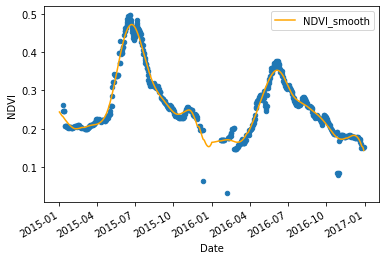

In [12]:
ax1 = df_out_ndvi[df_out_ndvi['Id'] == '10S_P1'].plot.scatter(x='Date', y='NDVI')
df_out_ndvi[df_out_ndvi['Id'] == '10S_P1'].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)

In [50]:
# get the LMF netcdf dataset for the year
lmfPATH_yr = glob(os.path.join(lmfDIR, 'CPER_' + str(yr) + '*.nc'))
# load the dataset to memory after masking
lmf_ds = riox.open_rasterio(lmfPATH_yr[0], 
              nodata=-9999, mask=True).sel(x=slice(bbox[0], bbox[2]),
                                           y=slice(bbox[3], bbox[1]))#.load()

In [66]:
# chunk the dataset for efficient processing
lmf_ds = lmf_ds.chunk({'DOY': -1, 'y': 50, 'x': 50})
lmf_ds

<xarray.Dataset>
Dimensions:      (DOY: 365, x: 314, y: 286)
Coordinates:
  * DOY          (DOY) float64 1.0 2.0 3.0 4.0 5.0 ... 362.0 363.0 364.0 365.0
  * x            (x) float64 5.177e+05 5.178e+05 ... 5.271e+05 5.271e+05
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
    spatial_ref  int64 0
Data variables:
    BLUE         (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    GREEN        (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    RED          (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    NIR1         (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    SWIR1        (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    SWIR2        (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
Attributes: (12/15)
    add_offset:        0
    bands:             1
    byte_order:        0
    data_type:         2
    description:       predicted fine resolution reflectance for sub_nbar.T13...
    file_type:         ENVI Standard
    ...                ...
    samples:           1000
    scale_factor:      1
    sensor_type:       Unknown
    wavelength_units:  Unknown
    x_start:           1
    y_start:           1

In [73]:
# create an xarray mask from the ground data
mask_info = gdf_plot.drop_duplicates(
    subset=['Id_plot'])[['Id_plot', 'geometry']].reset_index(drop=True).reset_index().rename(
    columns={'index': 'id'})
mask_shp = [(row.geometry, row.id+1) for _, row in mask_info.iterrows()]
plot_mask = shp2mask(shp=mask_shp, 
                     transform=lmf_ds.rio.transform(), 
                     outshape=lmf_ds['BLUE'].shape[1:], 
                     xr_object=lmf_ds['BLUE'])
mask_dict = {row.id+1: row.Id_plot for _, row in mask_info.iterrows()}
mask_dict[0] = 'UNK'
plot_mask = np.array([mask_dict[i] for i in plot_mask.values.flatten()]).reshape(plot_mask.shape)

In [74]:
# lazy compute all vegetation indices
lmf_ds['NDVI'] = ndvi_func(lmf_ds)

In [76]:
lmf_ds_c = lmf_ds.compute()

In [82]:
lmf_ds = lmf_ds_c

In [85]:
lmf_ds

<xarray.Dataset>
Dimensions:      (DOY: 365, x: 314, y: 286)
Coordinates:
  * DOY          (DOY) float64 1.0 2.0 3.0 4.0 5.0 ... 362.0 363.0 364.0 365.0
  * x            (x) float64 5.177e+05 5.178e+05 ... 5.271e+05 5.271e+05
  * y            (y) float64 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
    spatial_ref  int64 0
    Plot         (y, x) <U7 dask.array<chunksize=(50, 50), meta=np.ndarray>
Data variables:
    BLUE         (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    GREEN        (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    RED          (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    NIR1         (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    SWIR1        (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    SWIR2        (DOY, y, x) int16 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
    NDVI         (DOY, y, x) float64 dask.array<chunksize=(365, 50, 50), meta=np.ndarray>
Attributes: (12/15)
    add_offset:        0
    bands:             1
    byte_order:        0
    data_type:         2
    description:       predicted fine resolution reflectance for sub_nbar.T13...
    file_type:         ENVI Standard
    ...                ...
    samples:           1000
    scale_factor:      1
    sensor_type:       Unknown
    wavelength_units:  Unknown
    x_start:           1
    y_start:           1

In [84]:
# assign the plot id's to the xarray dataset
lmf_ds = lmf_ds.assign(Plot=(['y', 'x'], plot_mask)).chunk({'y': 50, 'x': 50})
lmf_ds = lmf_ds.set_coords('Plot')

In [86]:
# mask out areas outside ground plots
lmf_ds = lmf_ds.where(lmf_ds['Plot'] != 'UNK')

In [87]:
# convert to dataframe at plot scale
df_yr = lmf_ds['NDVI'].groupby('Plot').mean('stacked_y_x').to_dataframe().reset_index()

In [88]:
df_yr

,DOY,Plot,spatial_ref,NDVI
0,1.0,10S_P1,0,NaN
1,1.0,10S_P2,0,NaN
2,1.0,10S_P3,0,NaN
3,1.0,10S_P4,0,NaN
4,1.0,15E_P1,0,NaN
...,...,...,...,...
36860,365.0,8E_P1,0,0.165800
36861,365.0,8E_P2,0,0.165974
36862,365.0,8E_P3,0,0.157685
36863,365.0,8E_P4,0,0.153904


In [53]:
from rasterio.plot import show

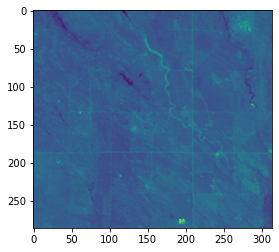

<AxesSubplot:>

In [64]:
show(lmf_ds.sel(DOY=220)['BLUE'].data)

In [54]:
show(lmf_ds.sel(DOY=1)[.data)

AttributeError: 'Dataset' object has no attribute 'data'